# Heart Dataset of 1k Cells from Mice

For this experiment, we will be doing low throughput analysis on a mice dataset, specifically tissue from their heart. The dataset consists of 1000 heart cells from an E18 mouse. 

### Import Libraries

To begin, let's run the following two cells to install the libraries and packages that we will need for our analysis.

In [ ]:
!pip install scanpy
!pip install harmonypy
!pip install scikit-misc
!pip3 install leidenalg

     |████████████████████████████████| 11.3MB 202kB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
     |████████████████████████████████| 133kB 52.4MB/s 
     |████████████████████████████████| 1.1MB 33.1MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=d8c03e642869ebe321465dc403849a21d3dc938099d44c1bc65ccb458b5bb628
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for sinfo: filename=sinfo-0.3.4-cp37-none-any.whl size=7899 sha256=344da9e21c6533cc6fa3257e83b624612b58336ec47bfea6512b4bc794686988
  Stored in directory: /root/.cache/pip/wheels/43/a4/e5/d4e0a170ccc134e509ea55acad7845f0fdfa62b964e430f0e3
  Created wheel for pynndescent: filename=pynndescent-0.5.3-cp37-none-any.whl size=52326 sha256=def85189e6286f85606a007553b9997d1a251ad570c20c978a7d9dbf2f6e25e9
  Stored in directory: /root/.cache/pip/wh

In [ ]:
import numpy as np
import pandas as pd
import sys
import scanpy as sc
import seaborn as sb
import matplotlib.pyplot as plt


### Parse Commands and Import data

#### Default hyperparameters

In [ ]:
# file_location = "data/"
batch_effect = None
n=-1                    #Initialized later
cluster_res = 1.0
min_cells = -1
min_genes = -1

#### Argument names

In [ ]:
file_arg = "--loc"
batch_arg = "--batch"
n_arg = "--neighbors"
resoution_arg = "--res"
cell_arg = "--min_cells"
gene_arg = "--min_genes"

#### Parse arguments

In [ ]:
args = sys.argv[1:]
for arg in args:
    if file_arg+"=" in arg:
        file_location = arg[arg.index("=") + 1:]
    elif batch_arg+"=" in arg:
        batch_effect = arg[arg.index("=") + 1:]
    elif n_arg+"=" in arg:
        n = int(arg[arg.index("=") + 1:])
    elif resoution_arg+"=" in arg:
        cluster_res = float(arg[arg.index("=") + 1:])
    elif cell_arg+"=" in arg:
        min_cells = float(arg[arg.index("=") + 1:])
    elif gene_arg+"=" in arg:
        min_genes = float(arg[arg.index("=") + 1:])

#### Import data  and Initialize n if not initialized

In [ ]:
adata = sc.read_10x_mtx("data/")
if n == -1:
  n = round(np.sqrt(adata.n_obs))

In [ ]:
(("File: "+ file_location), ("Batch: "+str(batch_effect)), ("Neighbors: "+str(n)), ("Resolution: "+str(cluster_res)))

('File: data/', 'Batch: None', 'Neighbors: 32', 'Resolution: 1.0')

### View Data

In [ ]:
print("adata.obs length: "+str(adata.n_obs))
adata.obs.head()

adata.obs length: 1011


""
AAACCCACACCAGTAT-1
AAACCCAGTCACCTTC-1
AAACCCAGTGGAACAC-1
AAACGAAAGTGCCCGT-1
AAACGAAGTCAGGTGA-1


In [ ]:
adata.X

<1011x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 2713934 stored elements in Compressed Sparse Row format>

In [ ]:
print("adata.var length: "+str(adata.n_vars))
adata.var.head()

adata.var length: 32285


,gene_ids,feature_types
Xkr4,ENSMUSG00000051951,Gene Expression
Gm1992,ENSMUSG00000089699,Gene Expression
Gm19938,ENSMUSG00000102331,Gene Expression
Gm37381,ENSMUSG00000102343,Gene Expression
Rp1,ENSMUSG00000025900,Gene Expression


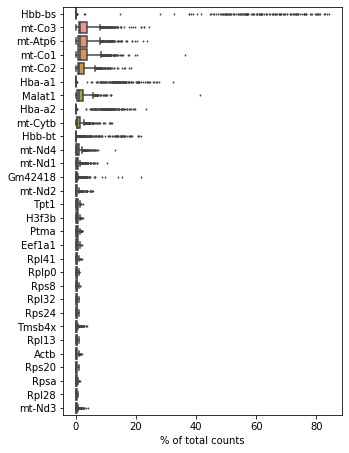

In [ ]:
sc.pl.highest_expr_genes(adata)

## Quality Control

### Basic Filtering

sc.pp.calculate_qc_metrics will give us 2 dataframes, a cell quality dataframe and a gene quality dataframe.

In [ ]:
# Quality control - calculate QC cmetrics
stats = sc.pp.calculate_qc_metrics(adata)
cell_qc_dataframe = stats[0]
gene_qc_dataframe = stats[1]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Lets take a quick look at the cell and gene qc dataframes.

In [ ]:
cell_qc_dataframe.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACCCACACCAGTAT-1,4140,8.328693,16861.0,9.732818,27.530989,39.742601,50.750252,63.323646
AAACCCAGTCACCTTC-1,2677,7.892826,6687.0,8.808070,25.078511,34.335277,44.608943,59.608195
AAACCCAGTGGAACAC-1,4296,8.365672,17340.0,9.760829,26.101499,36.257209,46.960784,61.043829
AAACGAAAGTGCCCGT-1,1848,7.522400,3867.0,8.260493,28.213085,37.134730,46.832170,64.054823
AAACGAAGTCAGGTGA-1,110,4.709530,5485.0,8.609955,98.906108,99.817685,100.000000,100.000000


In [ ]:
gene_qc_dataframe.head()

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
Xkr4,2,0.001978,0.001976,99.802176,2.0,1.098612
Gm1992,0,0.000000,0.000000,100.000000,0.0,0.000000
Gm19938,13,0.019782,0.019589,98.714144,20.0,3.044523
Gm37381,0,0.000000,0.000000,100.000000,0.0,0.000000
Rp1,2,0.001978,0.001976,99.802176,2.0,1.098612


These metrics will be used to graph our quality control graphs to find thresholds.

Looking at this graph, user must decide where to do the minimum cutoff for minimum genes. It is necessary to filter cells based on minimum genes because with that threshold, we can filter cells that have may have been contaminated. Our data here is extremely abnormal, as a large number of cells only have a small amount of genes. Lets take a closer look.

Text(0, 0.5, 'N cells')

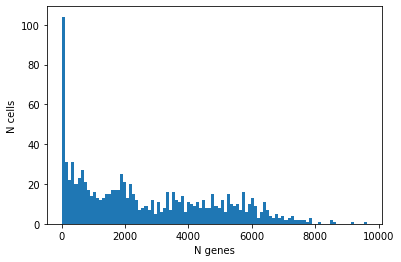

In [ ]:
plt.hist(cell_qc_dataframe['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')


A disturbed graph will have a peak on the an abnormal peak and dip before heading into the standard distribution peak. However in our heart dataset here, we have an abnormal absolute maximum, that never reaches even close to that level again. 200 may be a good cutoff but depending on the experiment, (for example, examining infected tissue), than these cells may be important and MUST be included in the data analysis. The threshold here is dependent on user input. 


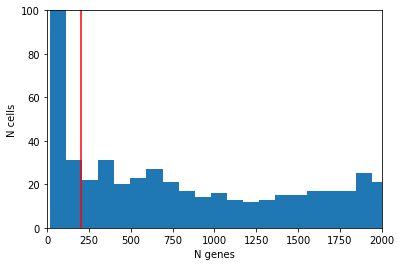

In [ ]:
plt.hist(cell_qc_dataframe['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.axvline(200, color='red')
plt.axis([0, 2000, 0, 100])
plt.show()

Our next order of business is to filter out genes that who have low expression levels across cells. It is important to do gene filtering after cell filtering because some genes may be detected only in low quality cells. 

Lets start by graphing cells vs the number of genes they express. 

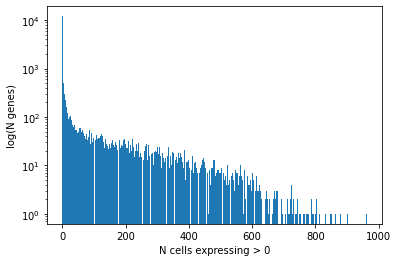

In [ ]:
plt.hist(gene_qc_dataframe['n_cells_by_counts'], bins=1000)
plt.xlabel('N cells expressing > 0')
plt.ylabel('log(N genes)') 
plt.yscale('log') 

It seems as if most cells express a good number of genes, which we would expect as a cell. Lets take a closer look at at around zero.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


(0.0, 20.0, 0.6251795688168253, 1000000.0)

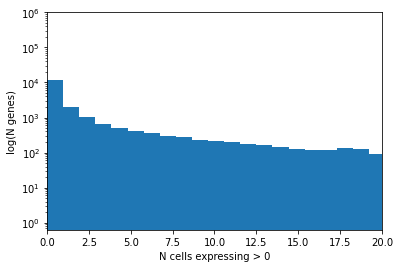

In [ ]:
plt.hist(gene_qc_dataframe['n_cells_by_counts'], bins=1000)
plt.xlabel('N cells expressing > 0')
plt.ylabel('log(N genes)') 
plt.yscale('log')
plt.axis([0, 20, 0, 1000000])


We see a weird peak at around about 1 or 2 cells which may be a good min_cells for removing our genes. 




***
For our defaults, because basic filtering be extremely variable throughout experiments, we have decided to keep defaults at zero until user input after seeing graphs. Since in our neuron set, we have already demonstrated this, lets just choose our user inputs, 200 min genes and 2 min cells looks good. 

**To be changed**

In [ ]:
cell_filter = 200 
gene_filter = 2

#### Filter

In [ ]:
sc.pp.filter_cells(adata, min_genes = cell_filter)
sc.pp.filter_genes(adata, min_cells = gene_filter)

### Batch Correction Effect

In [ ]:
# Review obs after draft is complete
if not batch_effect == None:
  sc.pp.pca(adata)
  sc.external.pp.harmony_integrate(adata, key=batch_effect)

### Normalize and Logarithmize Data

As its name suggests, sc.pp.normalize_total will normalize the total number of counts per cell so that every cell will have the same number of total counts. Normalization will help to preserve biological heterogeneity without the influence of any technical noise like sequencing depth and gene abundance.

target_sum = 1e6 here refers to counts per million. 

sc.pp.log1p helps to logarithmize the data to improve data "symmetry" on a linear scale for more relevant and accurate data. For further information on this topic, feel free to check out the following link: https://blog.qbaseplus.com/seven-tips-for-bio-statistical-analysis-of-gene-expression-data

In [ ]:
sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata)

### Remove highly variable genes

Determine and remove highly variable genes based on each genes' mean and variance. Removing these genes eliminates noise due to high variability in the data.

Algorithm: Each gene is put into 20 'bins' based and their mean and variance. Each gene is then normalized based on the other genes in their bin. If a gene's normalized dispersion is greater or equal to a z-score of 2 (~98th percentile) AND the gene has a low mean cell count, it is marked highly variable.

Note: warning just means it will proceed to automatically calculate PCA since it was not done beforehand.

In [ ]:
sc.pp.highly_variable_genes(adata, flavor='seurat', min_disp=2)
adata = adata[:, adata.var.highly_variable==False]

### K-Nearest Neighbors

Calculate the distance between each cell using the KNN algorithm. Distances will be used to cluster the cells in the next step.

In [ ]:
sc.pp.neighbors(adata, n_neighbors=n)

         Falling back to preprocessing with `sc.pp.pca` and default params.


### Cluster

Cluster/Group each cell based on the distances calculated in the previous step using the Leiden algorithm.

'resolution' determines the amount of clusters that will be formed (default: 1.0. The higher the resolution, the more clusters in the result)

In [ ]:
sc.tl.leiden(adata, resolution=cluster_res)

## Visualize Results

Prepares the data to be visualized by simplifying multiple dimensions down to two dimensional coordinates using the UMAP algorithm. 

This algoithm also uses the distances calculated using 'neighbors()' 

In [ ]:
sc.tl.umap(adata)

### Clusters

Plot the UMAP data and color based on the clusters determined previously.

... storing 'feature_types' as categorical


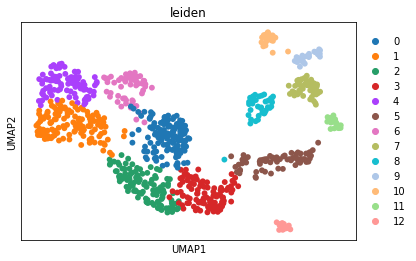

In [ ]:
sc.pl.umap(adata, color=['leiden'])

### Color based on selected gene(s)

Color cells based on their expression of a specific gene. The first 16 genes in the list are displayed.

Note: purple = no expression

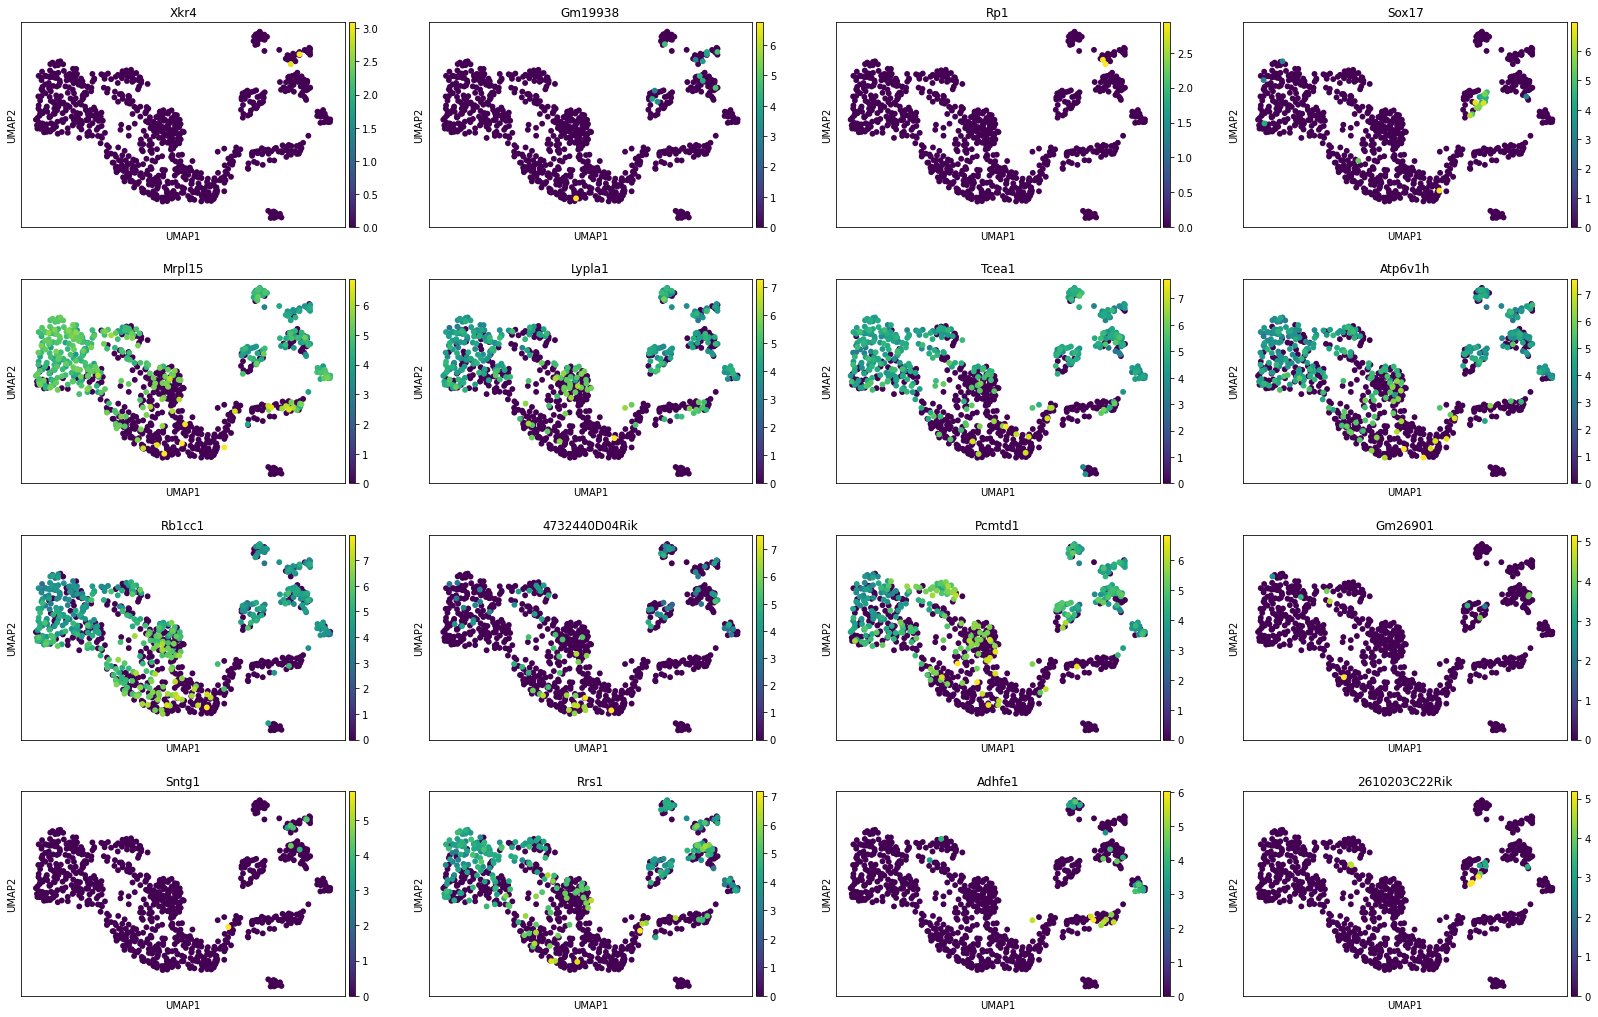

In [ ]:
#View the first 16 genes
genes = []
i = 16
for gene in adata.var_names:
  genes.append(gene)
  i -= 1
  if i==0: break

sc.pl.umap(adata, color=genes)